# Import important libraries

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans

## 0. Reusable function

In [92]:
def visualize_dataset(dataset):
    """
    Visualizes a 2D dataset using a scatter plot.

    Args:
        dataset (numpy.ndarray): A numpy array of shape (n, 2) containing the data points.
    """
    plt.figure(figsize=(8, 6)) 
    plt.scatter(dataset[:, 0], dataset[:, 1], s=10)
    plt.title('Toy Dataset Visualization')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.savefig('img/unclustered_dataset.png')
    plt.show()

## 1. Assignment 01

### 1.1. Task 01
Generate a toy dataset having $600$ data points, $200$ points of them following the Gaussian distribution $\mathcal{N}((2, 2), \Sigma)$, $200$ points of them following the Gaussian distribution $\mathcal{N}((8, 3), \Sigma)$, and $200$ points of them following the Gaussian distribution $\mathcal{N}((3, 6), \Sigma)$ where $\Sigma = 
\left(\begin{array}{cc}
    1 & 0 \\
    0 & 1
\end{array}\right)
$.

In [93]:
def generate_dataset():
    """
    Generates a toy dataset with 600 data points from three Gaussian distributions.

    The dataset consists of:
    - 200 points from N((2, 2), Sigma)
    - 200 points from N((8, 3), Sigma)
    - 200 points from N((3, 6), Sigma)
    where Sigma is the 2x2 identity matrix.

    Returns:
        numpy.ndarray: A numpy array of shape (600, 2) containing the generated data points.
    """
    # Define the means for the three Gaussian distributions
    mean1 = np.array([2, 2])
    mean2 = np.array([8, 3])
    mean3 = np.array([3, 6])

    covariance = np.array([[1, 0], [0, 1]])
    num_points_per_cluster = 200

    # Generate data points from the 1st, 2nd, 3rd Gaussian distribution
    data_cluster1 = np.random.multivariate_normal(mean1, covariance, num_points_per_cluster)
    data_cluster2 = np.random.multivariate_normal(mean2, covariance, num_points_per_cluster)
    data_cluster3 = np.random.multivariate_normal(mean3, covariance, num_points_per_cluster)

    # Concatenate the data from the three clusters
    toy_dataset = np.concatenate((data_cluster1, data_cluster2, data_cluster3), axis=0)

    return toy_dataset

In [94]:
dataset1 = generate_dataset()
dataset1

array([[2.56398441, 3.07830598],
       [3.46926053, 1.87287119],
       [1.19687158, 1.46271129],
       ...,
       [2.6271336 , 6.4981105 ],
       [2.39868903, 6.61784714],
       [1.93066189, 7.66877934]], shape=(600, 2))

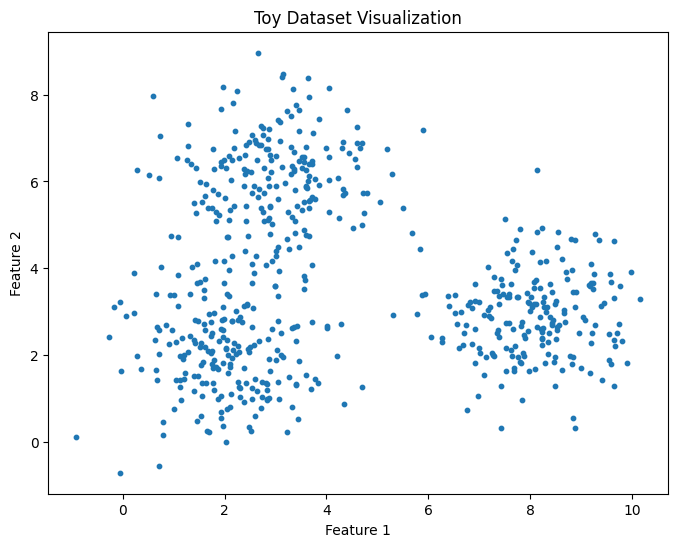

In [95]:
visualize_dataset(dataset=dataset1)

### 1.2. Task 02
- Use Numpy only to implement the K-means method for finding three clusters from the toy dataset.
- Train this K-means with EM method.

In [96]:
clustered_dataset1 = {
    0: {'list': [dataset1[0]], 'centroid': dataset1[0]},
    1: {'list': [dataset1[1]], 'centroid': dataset1[1]},
    2: {'list': [dataset1[2]], 'centroid': dataset1[2]},
}
for cluster in clustered_dataset1:
    print(cluster)

0
1
2


In [97]:
def calculate_distance(_datapoint: list[float], _centroid: list[float]) -> float:

    _distance = np.sqrt(
        (_datapoint[0] - _centroid[0])**2 + (_datapoint[1] - _centroid[1])**2
    )
    return _distance


calculate_distance([0, 0], [3, 4])

np.float64(5.0)

In [98]:
def find_nearestCluster(_datapoint: list[float], _clusters: dict):
    _distance = calculate_distance(_datapoint, _clusters[0]['centroid'])
    _index = 0
    for cluster in _clusters:
        _distance2 = calculate_distance(_datapoint, _clusters[cluster]['centroid'])
        if _distance2 < _distance:
            _index = cluster
            _distance = _distance2
        
    return _index


In [99]:
def update_latestCentroid(data_list):
  if not data_list:
    print("Warning: Input list is empty. Cannot calculate centroid.")
    return None

  data_array = np.array(data_list)
  centroid = np.mean(data_array, axis=0)

  return centroid

In [100]:
for i, row in enumerate(dataset1, start=0):
    if i < 3:
        continue
    
    index = find_nearestCluster(row, clustered_dataset1)
    clustered_dataset1[index]['list'].append(row)
    clustered_dataset1[index]['centroid'] = update_latestCentroid(clustered_dataset1[index]['list'])

cluster1 = np.array(clustered_dataset1[0]['list'])
cluster2 = np.array(clustered_dataset1[1]['list'])
cluster3 = np.array(clustered_dataset1[2]['list'])

In [101]:
cluster1[:,0]

array([ 2.56398441,  2.54667699,  1.01630142,  2.08810208,  2.27057122,
        1.09039206,  0.23126673,  1.98238067,  1.96654186,  1.95718616,
        1.59413944,  0.07097115, -0.26944001,  0.64561082,  2.08658395,
        0.92208193,  1.36830811,  1.31993103, -0.06278189,  2.22499552,
        3.05314868,  1.93253601,  1.4240201 ,  1.73080351,  1.60383356,
        2.13601477,  1.03898849,  2.14193958,  1.58676802,  2.44198937,
        2.19171981,  1.61968011,  1.96517103,  2.33504178,  1.32075519,
        1.46515897,  2.5364245 ,  1.75121068,  1.96974979,  1.62004966,
        1.48289995,  2.05034033,  1.08123358,  3.06359619,  2.38735457,
        2.15396852,  1.51927562,  3.569298  ,  3.56092464,  2.9983101 ,
        0.67822728,  2.29360972,  1.88818405,  0.71814292,  0.21233731,
        1.6937609 ,  2.44563149,  2.98422056,  0.63601509,  1.98303346,
        0.85199538, -0.16301132,  1.16827618,  1.74186318,  1.78497306,
        3.52467006,  3.18793589,  1.08822556,  0.27966707,  2.76

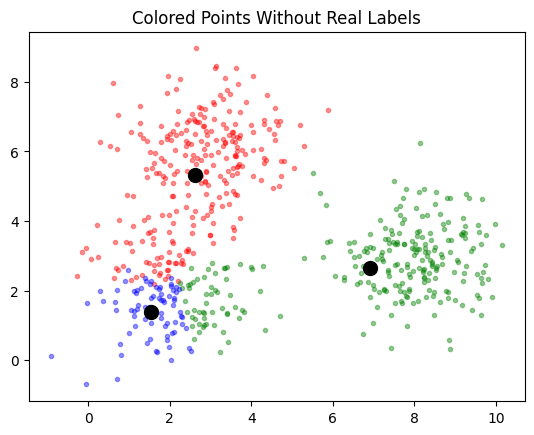

In [102]:
def visualize_assignment1():
    plt.scatter(cluster1[:, 0], 
                cluster1[:, 1], 
                color='red', 
                alpha = 0.4,
                marker='.'
    )
    plt.scatter(clustered_dataset1[0]['centroid'][0],
            clustered_dataset1[0]['centroid'][1],
            color='black',
            s=100
    )

    plt.scatter(cluster2[:, 0], 
                cluster2[:, 1], 
                color='green', 
                alpha = 0.4,
                marker='.'
    )
    plt.scatter(clustered_dataset1[1]['centroid'][0],
            clustered_dataset1[1]['centroid'][1],
            color='black',
            s=100
    )

    plt.scatter(cluster3[:, 0], 
                cluster3[:, 1], 
                color='blue', 
                alpha = 0.4,
                marker='.'
    )
    plt.scatter(clustered_dataset1[2]['centroid'][0],
            clustered_dataset1[2]['centroid'][1],
            color='black',
            s=100
    )
    plt.title("Colored Points Without Real Labels")

    plt.savefig('img/clustered_assignment01.png')

visualize_assignment1()